In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(0, 2)
qc.draw()

q_0: ──■─────────■──
     ┌─┴─┐       │  
q_1: ┤ X ├──■────┼──
     └───┘┌─┴─┐┌─┴─┐
q_2: ─────┤ X ├┤ X ├
          └───┘└───┘

In [3]:
# pass manager is given dag, so use this as input to our mock functions
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qc)

In [4]:
# looking up index of a qubit in the circuit
for node in dag.topological_op_nodes():
    print([QuantumCircuit.find_bit(qc, arg).index for arg in node.qargs])

[0, 1]
[1, 2]
[0, 2]


In [5]:
# basic cost function
from qiskit.converters import dag_to_circuit


def get_cost(dag, layout):
    qc = dag_to_circuit(dag)
    cost = 0
    for node in dag.topological_op_nodes():
        bit_indices = [QuantumCircuit.find_bit(qc, arg).index for arg in node.qargs]
        # convert to physical qubit indices
        physical_indices = [layout[bit_index] for bit_index in bit_indices]
        # get the topological distance
        distance = abs(physical_indices[0] - physical_indices[1]) - 1
        cost += distance
    return cost


layout = {0: 0, 1: 1, 2: 2}
get_cost(dag, layout)

1

In [6]:
# cost function that updates layout on marked nodes
# mark the first op node in the dag with a new attribute
dag.op_nodes()[1].name = "cx_m"

In [7]:
# cost function that updates layout on marked nodes
from qiskit.converters import dag_to_circuit

"""Use physical_indices here, but note that this changes dynamical with the topological order of the circuit.
This means make sure don't lose the initial layout and discard the physical_indices at end.
"""


def get_updated_cost(dag, layout):
    qc = dag_to_circuit(dag)
    cost = 0
    for node in dag.topological_op_nodes():
        bit_indices = [QuantumCircuit.find_bit(qc, arg).index for arg in node.qargs]
        # convert to physical qubit indices
        physical_indices = [layout[bit_index] for bit_index in bit_indices]
        # get the topological distance
        distance = abs(physical_indices[0] - physical_indices[1]) - 1
        cost += distance

        # update layout if marked node
        if node.name == "cx_m":
            layout[bit_indices[0]], layout[bit_indices[1]] = (
                layout[bit_indices[1]],
                layout[bit_indices[0]],
            )

    return cost


layout = {0: 0, 1: 1, 2: 2}
get_updated_cost(dag, layout)

0

In [8]:
for node in dag.two_qubit_ops():
    print(node.name)

cx
cx_m
cx


In [9]:
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    Unroller,
    TrivialLayout,
    ApplyLayout,
    SabreLayout,
    CountOpsLongestPath,
)
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
import numpy as np

from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

# this code is buggy, see https://github.com/Qiskit/qiskit-terra/pull/9375
# I can't use this version bc qiskit version missing DAGCircuit functionality

# build a toffoli
qc = QuantumCircuit(8)
qc.ccx(0, 1, 2)
qc.cx(1, 7)
qc.ccx(3, 4, 5)
qc.ccx(2, 5, 6)
# build a 2x2 square coupling map
coupling = CouplingMap.from_line(8)

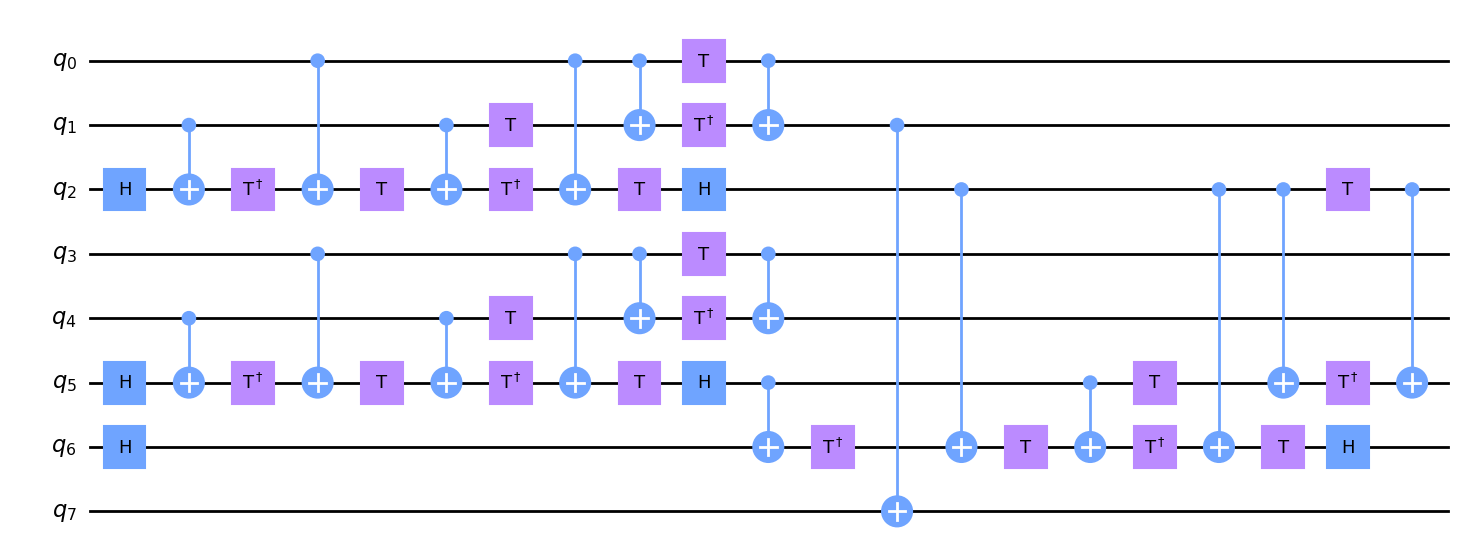

In [10]:
qc.decompose().draw(output="mpl")

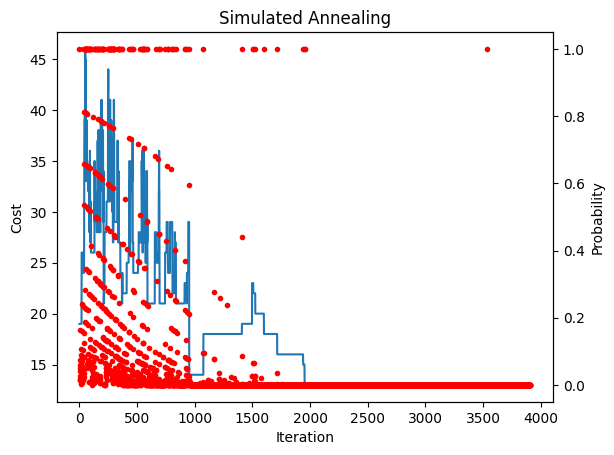

                                                      ┌───┐                    »
q_0: ─────────────────────────────────────────────────┤ X ├────────────────────»
                         ┌────────────┐               └─┬─┘     ┌─────────────┐»
q_1: ─────────────────■──┤ U(0,0,π/4) ├────X────────────■───────┤ U(0,0,-π/4) ├»
      ┌────────────┐┌─┴─┐└────────────┘    │                    └─────────────┘»
q_2: ─┤ U(π/2,0,π) ├┤ X ├──────X───────────X───────────────────────────X───────»
      └────────────┘└───┘      │       ┌────────┐┌─────────────┐       │       »
q_3: ──────────────────────────X───────┤0       ├┤ U(0,0,-π/4) ├───────X───────»
      ┌────────────┐                   │  Iswap │├─────────────┤   ┌────────┐  »
q_4: ─┤ U(0,0,π/4) ├──X────────────────┤1       ├┤ U(0,0,-π/4) ├───┤1       ├──»
     ┌┴────────────┤  │                └────────┘└─────────────┘   │  Iswap │  »
q_5: ┤ U(0,0,-π/4) ├──X────────────────────────────────────────────┤0       ├──»
     └─────────────┘        

KeyError: 'iswap'

In [11]:
from virtual_swap.vswap_simple import VirtualSwap

# run the pass
pm = PassManager()
# need some basic unroll and layout
pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
pm.append(VirtualSwap(coupling, visualize=True))
pm.append(OptimizeSwapBeforeMeasure())

# XXX use the PR version once merged into Qiskit
# pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
pm.append([CountOpsLongestPath()])

# set debug logging
# import logging

# logger = logging.getLogger("VSWAP")
# logger.setLevel(logging.INFO)

new_circ = pm.run(qc)

# sum the cost of gate 'cx' and 'iswap'
print(
    f"Gate count:", 2 * new_circ.count_ops()["iswap"] + 2 * new_circ.count_ops()["cx"]
)
longest_path = pm.property_set["count_ops_longest_path"]
print(f"Longest path gate count:", 2 * longest_path["iswap"] + 2 * longest_path["cx"])

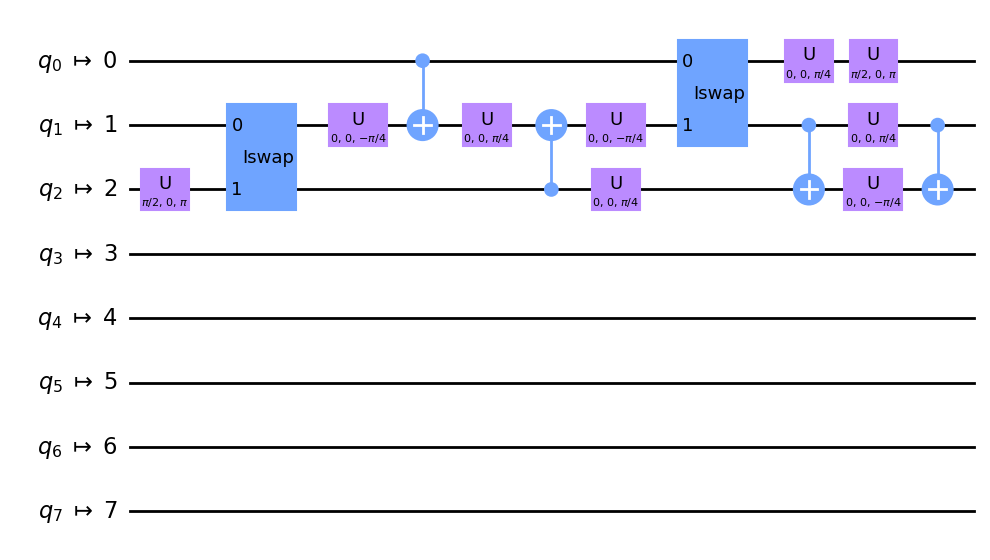

In [ ]:
new_circ.draw(output="mpl")

In [3]:
from qiskit.dagcircuit import DAGOpNode, DAGCircuit
from weylchamber import c1c2c3
from qiskit.circuit.library import iSwapGate, CXGate
from qiskit.transpiler import Layout
from qiskit.transpiler.basepasses import TransformationPass
import numpy as np


class TestCNSTransform(TransformationPass):
    def __init__(self, coupling_map, **kwargs):
        super().__init__()
        self.coupling_map = coupling_map

    def run(self, dag):
        # annotate nodes
        for node in dag.op_nodes():
            node.flag = True

        return self._transform_CNS(dag.op_nodes()[0], dag)

    def _transform_CNS(self, node: DAGOpNode, dag: DAGCircuit) -> DAGCircuit:
        """Transform CX into iSWAP+SWAP or iSWAP into CX+SWAP.

        Applies changes to 'dag' in-place. Uses virtual-swap; no real SWAPs added.
        Instead of SWAP, update layout and gate placements.

        Args:
            node_index (int): Index of node to transform.
            dag (DAGCircuit): DAG to transform.

        Returns:
            DAGCircuit: Transformed DAG.
        """
        # 1. transform node in temp_dag
        # XXX will need to define the sub rules more exactly
        coord = c1c2c3(np.array(node.op))
        if coord == (0.5, 0, 0):
            # transform CX into iSWAP
            # XXX not preserving unitary correctness
            dag.substitute_node(node, iSwapGate(), inplace=True)
        elif coord == (0.5, 0.5, 0):
            # transform iSWAP into CX
            # XXX not preserving unitary correctness
            dag.substitute_node(node, CXGate(), inplace=True)
        else:
            raise ValueError(f"Invalid node: {node}")

        # 2. propagate changes down the DAG
        # NOTE there is definitely a better way to do this
        # find clever use of dag.substitute_node_with_dag

        # placement of the virtual-swap gate
        # copy maybe not necessary, keep for safety :)
        working_layout = self.property_set["layout"].copy()
        working_layout.swap(node.qargs[0], node.qargs[1])

        # update gate-wire placement
        for successor_node in dag.descendants(node):
            if isinstance(successor_node, DAGOpNode):
                successor_node.qargs = [
                    working_layout[qarg.index] for qarg in successor_node.qargs
                ]

        return dag

In [4]:
from qiskit import QuantumCircuit
from qiskit.transpiler.coupling import CouplingMap
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import TrivialLayout
import numpy as np

qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.cx(1, 2)
qc.u(np.pi / 2, np.pi / 2, np.pi / 2, 0)

print(qc.draw())

coupling = CouplingMap.from_line(3)

pm = PassManager()
pm.append(TrivialLayout(coupling))
pm.append(TestCNSTransform(coupling))

pm.run(qc).draw(output="mpl")

          ┌────────────────┐
q_0: ──■──┤ U(π/2,π/2,π/2) ├
     ┌─┴─┐└────────────────┘
q_1: ┤ X ├────────■─────────
     └───┘      ┌─┴─┐       
q_2: ───────────┤ X ├───────
                └───┘       


AttributeError: 'DAGOpNode' object has no attribute 'flag'